## Load the Model

In [1]:
import numpy as np
import torch
import torch.nn as nn
# Choose the `x3d_s` model
model_name = 'x3d_m'
model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)

Using cache found in /Users/phuber/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [2]:
import json
import urllib
from pytorchvideo.data.encoded_video import EncodedVideo

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

## Setup Device

In [3]:
# Set to GPU or CPU
device = "cpu"
model = model.eval()
model = model.to(device)

## Download Labels

In [4]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

In [5]:
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

## Define input transforms

In [6]:
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
frames_per_second = 30
model_transform_params  = {
    "x3d_xs": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 4,
        "sampling_rate": 12,
    },
    "x3d_s": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 13,
        "sampling_rate": 6,
    },
    "x3d_m": {
        "side_size": 256,
        "crop_size": 256,
        "num_frames": 16,
        "sampling_rate": 5,
    }
}

# Get transform parameters based on model
transform_params = model_transform_params[model_name]

# Note that this transform is specific to the slow_R50 model.
transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(transform_params["num_frames"]),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(size=transform_params["side_size"]),
            CenterCropVideo(
                crop_size=(transform_params["crop_size"], transform_params["crop_size"])
            )
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (transform_params["num_frames"] * transform_params["sampling_rate"])/frames_per_second

## Download Video

In [7]:
url_link = "https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4"
video_path = 'archery.mp4'
try: urllib.URLopener().retrieve(url_link, video_path)
except: urllib.request.urlretrieve(url_link, video_path)

In [8]:
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_org = video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
video_data = transform(video_org)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = inputs.to(device)
video = inputs[None, ...]

## Get Predictions

In [9]:
# Pass the input clip through the model
preds = model(video)

# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: archery, answering questions, applying cream, abseiling, air drumming


In [10]:
print(pred_classes)

tensor([5, 2, 4, 0, 1])


## Make Visualisations

In [11]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2
from scipy.ndimage import gaussian_filter

In [19]:
def pick_frame_as_numpy(video, n=3, heatmap=False, sigma=1):
    frame = np.transpose(video.squeeze()[:, n].cpu().detach().numpy(), (1,2,0))
    if heatmap:
        frame = gaussian_filter(frame, sigma=sigma)
    return frame

In [13]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


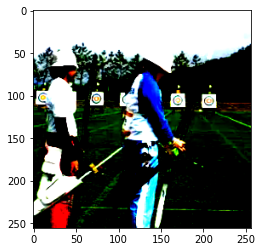

In [14]:
plt.imshow(pick_frame_as_numpy(video_org["video"]))

In [15]:
pred_label_idx = 5

In [16]:
integrated_gradients = IntegratedGradients(model)

## Attributions

In [17]:
attributions_ig = integrated_gradients.attribute(video, target=pred_label_idx, n_steps=10)

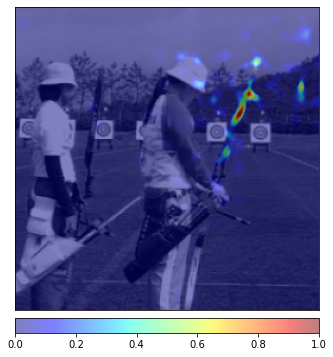

In [38]:
n = 7

_ = viz.visualize_image_attr(pick_frame_as_numpy(attributions_ig, n, True, 3),
                             pick_frame_as_numpy(video, n),
                             method='blended_heat_map',
                             cmap=cm.jet,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=0,
                             alpha_overlay=0.5,
                             )

In [33]:
heatmap = gaussian_filter(pick_frame_as_numpy(attributions_ig, n), sigma=5)


## Smoothening

In [24]:
noise_tunnel = NoiseTunnel(integrated_gradients)

In [ ]:
attributions_ig_nt = noise_tunnel.attribute(video, nt_samples=4, nt_type='smoothgrad_sq', target=pred_label_idx)

In [ ]:
_ = viz.visualize_image_attr_multiple(pick_frame_as_numpy(attributions_ig_nt),
                                      pick_frame_as_numpy(video),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
attributions_ig_nt = noise_tunnel.attribute(video, nt_samples=4, nt_type='smoothgrad_sq', target=292)
_ = viz.visualize_image_attr_multiple(pick_frame_as_numpy(attributions_ig_nt),
                                      pick_frame_as_numpy(video),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## GradientShap

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([video * 0, video * 1])

attributions_gs = gradient_shap.attribute(video,
                                          n_samples=4,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

In [ ]:
_ = viz.visualize_image_attr_multiple(pick_frame_as_numpy(attributions_gs),
                                      pick_frame_as_numpy(video),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Occlusion-based attribution

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(video,
                                       strides = (3, 16, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3, 16, 15, 15),
                                       baselines=0)

In [ ]:
_ = viz.visualize_image_attr_multiple(pick_frame_as_numpy(attributions_occ),
                                      pick_frame_as_numpy(video),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(video,
                                       strides = (3, 8, 10, 10),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3, 8, 50, 50),
                                       baselines=0)

In [ ]:
_ = viz.visualize_image_attr_multiple(pick_frame_as_numpy(attributions_occ),
                                      pick_frame_as_numpy(video),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
print(pick_frame_as_numpy(attributions_occ).shape)
print(pick_frame_as_numpy(video).shape)